This notebook presents experiments with two BERT-based models and includes error analysis.

## Install dependencies

In [2]:
!pip install datasets

In [3]:
!pip install evaluate

In [ ]:
# If needed:
#!pip install transformers --upgrade

In [4]:
# If needed:
!pip install numpy==1.26.4

In [5]:
import torch
import pandas as pd
import evaluate
import numpy as np
from datasets import Dataset

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load and Preprocess Datasets

In [6]:
# Load the datasets
# Make sure to check the file paths!

df_train = pd.read_csv("data/final/train_split.csv")

In [7]:
# Split the train set into two
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(df_train, train_size=0.8, random_state=42, shuffle=True)

# Check the shapes
print(f"Training set shape: {train_df.shape}")
print(f"Evaluation set shape: {eval_df.shape}")

Training set shape: (1920, 5)
Evaluation set shape: (480, 5)


In [8]:
df_test_1 = pd.read_csv("data/final/test_split_1.csv")
df_test_2 = pd.read_csv("data/final/test_split_2.csv")
df_test_3 = pd.read_csv("data/final/test_split_3.csv")

## Model 1: XLM-RoBERTa-Large-En-Ru-MNLI


In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
bert_tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/xlm-roberta-large-en-ru-mnli')
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/xlm-roberta-large-en-ru-mnli', num_labels=2,
                                                           ignore_mismatched_sizes=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/xlm-roberta-large-en-ru-mnli and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN 

In [10]:
# Convert dfs to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

test_dataset_1 = Dataset.from_pandas(df_test_1)
test_dataset_2 = Dataset.from_pandas(df_test_2)
test_dataset_3 = Dataset.from_pandas(df_test_3)

# Tokenize
def tokenize_function(examples):
    return bert_tokenizer(examples['texts'], truncation=True, padding='max_length', max_length=512)

# Tokenize all datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

test_dataset_1 = test_dataset_1.map(tokenize_function, batched=True)
test_dataset_2 = test_dataset_2.map(tokenize_function, batched=True)
test_dataset_3 = test_dataset_3.map(tokenize_function, batched=True)

# Rename the label column for compatibility with the Trainer
train_dataset = train_dataset.rename_column("class", "labels")
eval_dataset = eval_dataset.rename_column("class", "labels")

test_dataset_1 = test_dataset_1.rename_column("class", "labels")
test_dataset_2 = test_dataset_2.rename_column("class", "labels")
test_dataset_3 = test_dataset_3.rename_column("class", "labels")

# To PyTorch tensors format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

test_dataset_1.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_2.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_3.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Check
#print(train_dataset[0])
#print(eval_dataset[0])

Map:   0%|          | 0/1920 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [12]:
from transformers import set_seed, TrainingArguments, Trainer

set_seed(42)

training_args = TrainingArguments(
    output_dir = 'outputs/xlm/',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=12,
    fp16=True,
    logging_steps=10,
    num_train_epochs=3,
    seed=42,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end = True,
    report_to='none' # disable WB
)

In [14]:
# Evaluation
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return clf_metrics.compute(predictions=predictions, references=labels)

In [15]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [16]:
# Epoch 2 might be the best generalization point. After that shows signs of overfitting
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.405200,0.166851,0.945833,0.944444,0.936441,0.952586
2,0.142500,0.063326,0.981250,0.980645,0.978541,0.982759
3,0.034800,0.123448,0.970833,0.970588,0.946721,0.995690


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       297
           1       0.97      0.97      0.97       303

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



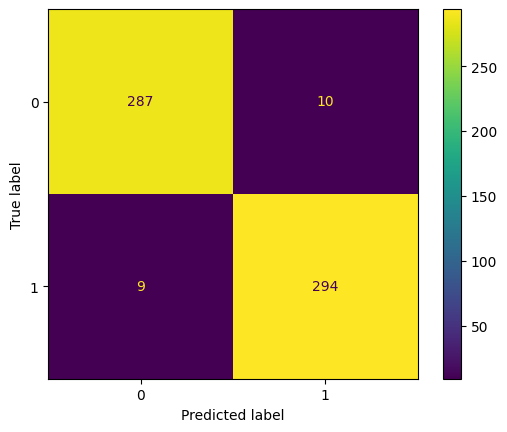

In [18]:
# Predictions on the test split 1
predictions_output_1 = trainer.predict(test_dataset_1)

# Extract predictions and true labels
y_pred_1_xlm = np.argmax(predictions_output_1.predictions, axis=-1)
y_true_1 = predictions_output_1.label_ids

print(classification_report(y_true_1, y_pred_1_xlm, digits=2))
ConfusionMatrixDisplay.from_predictions(y_true_1, y_pred_1_xlm)

# Save to file:
plt.savefig("plots/confusion_matrix_setup_1_xlm.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
def extract_errors(test_dataset, predictions, columns_to_drop=None):
    """
    Returns a DataFrame with misclassified examples and predicted labels.

    Parameters:
    - test_dataset: Hugging Face Dataset object.
    - predictions: numpy array of predicted class indices (already argmaxed if needed).
    - columns_to_drop: list of column names to exclude (e.g., ['input_ids', 'attention_mask']).

    Returns:
    - df_errors: pandas DataFrame containing misclassified rows and predicted labels.
    """
    # Convert dataset to pandas DataFrame
    test_dataset.set_format(type=None)  # Reset format to make it a normal dict
    df_test = pd.DataFrame(test_dataset)

    # Drop unnecessary columns
    if columns_to_drop:
        df_test = df_test.drop(columns=columns_to_drop, errors='ignore')

    # Add predictions
    df_test['predicted_label'] = predictions

    # Filter misclassified examples
    df_errors = df_test[df_test['labels'] != df_test['predicted_label']]

    return df_test, df_errors


In [20]:
columns_to_remove = ['input_ids', 'attention_mask']  # Optional

df_test_1, df_errors_1_xlm = extract_errors(test_dataset_1, y_pred_1_xlm, columns_to_remove)

# Print how many errors there were
print(f"Number of misclassifications in split 1: {len(df_errors_1_xlm)}")

Number of misclassifications in split 1: 19


In [21]:
df_errors_1_xlm.head()

,texts,source,word_counts,genre,labels,predicted_label
2,Міръ фантазіи\nТамъ негою веетъ вокругъ ветеро...,Дмитрий Петрович Ознобишин,69.0,poems,0,1
13,В заповеднике на Камчатке сфотографировали мыш...,ria.ru,68.0,news,0,1
39,"Ха, а позади меня сидели школотроны, хрустели ...",pikabu,11.0,social,0,1
53,Утешение\nСкрипит под санями сверкающий снег.\...,Андрей Белый,55.0,poems,0,1
89,"\nI \nКАЛУЖСКИЕ ВЕЧЕРА \nВечер тихий, как ...",chatgpt-4o-latest,104.0,poems,1,0


In [23]:
# Save to file
df_errors_1_xlm.to_csv("data/errors_setup_1_xlm_roberta.csv", index=False)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       297
           1       0.97      0.97      0.97       303

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



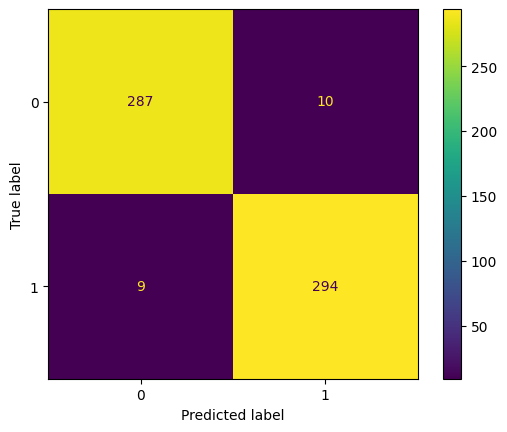

In [24]:
# Predictions on the test split 2
predictions_output_2 = trainer.predict(test_dataset_2)

# Extract predictions and true labels
y_pred_2_xlm = np.argmax(predictions_output_2.predictions, axis=-1)
y_true_2 = predictions_output_2.label_ids

print(classification_report(y_true_2, y_pred_2_xlm, digits=2))
ConfusionMatrixDisplay.from_predictions(y_true_2, y_pred_2_xlm)

# Save to file:
plt.savefig("plots/confusion_matrix_setup_2_xlm.png", dpi=300, bbox_inches='tight')
plt.show()

In [25]:
df_test_2, df_errors_2_xlm = extract_errors(test_dataset_2, y_pred_2_xlm, columns_to_remove)

# Print how many errors there were
print(f"Number of misclassifications in split 2: {len(df_errors_2_xlm)}")

Number of misclassifications in split 2: 19


In [26]:
# Save to file
df_errors_2_xlm.to_csv("data/errors_setup_2_xlm_roberta.csv", index=False)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       297
           1       0.97      0.97      0.97       303

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



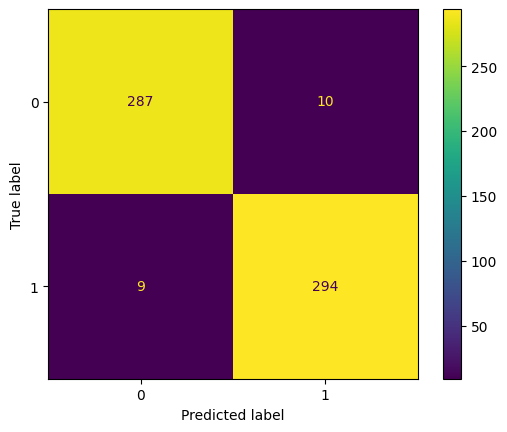

In [27]:
# Predictions on the test split 3
predictions_output_3 = trainer.predict(test_dataset_3)

# Extract predictions and true labels
y_pred_3_xlm = np.argmax(predictions_output_3.predictions, axis=-1)
y_true_3 = predictions_output_3.label_ids

print(classification_report(y_true_3, y_pred_3_xlm, digits=2))
ConfusionMatrixDisplay.from_predictions(y_true_3, y_pred_3_xlm)

# Save to file:
plt.savefig("plots/confusion_matrix_setup_3_xlm.png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
df_test_3, df_errors_3_xlm = extract_errors(test_dataset_3, y_pred_3_xlm, columns_to_remove)

# Print how many errors there were
print(f"Number of misclassifications in split 3: {len(df_errors_3_xlm)}")

Number of misclassifications in split 3: 19


In [29]:
# Save to file
df_errors_3_xlm.to_csv("data/errors_setup_3_xlm_roberta.csv", index=False)

## Model 2: ruRoberta-large
This part can be run independently of the first model.
Repeat the same steps for this model.

In [30]:
# Check the file paths!
df_train = pd.read_csv("data/final/train_split.csv")

# Split the train set into two
train_df, eval_df = train_test_split(df_train, train_size=0.8, random_state=42, shuffle=True)

# Check the shapes
print(f"Training set shape: {train_df.shape}")
print(f"Evaluation set shape: {eval_df.shape}")

Training set shape: (1920, 5)
Evaluation set shape: (480, 5)


In [31]:
df_test_1 = pd.read_csv("data/final/test_split_1.csv")
df_test_2 = pd.read_csv("data/final/test_split_2.csv")
df_test_3 = pd.read_csv("data/final/test_split_3.csv")

In [32]:
bert_tokenizer = AutoTokenizer.from_pretrained('ai-forever/ruRoberta-large')
model = AutoModelForSequenceClassification.from_pretrained('ai-forever/ruRoberta-large', num_labels=2,
                                                           ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Convert dfs to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

test_dataset_1 = Dataset.from_pandas(df_test_1)
test_dataset_2 = Dataset.from_pandas(df_test_2)
test_dataset_3 = Dataset.from_pandas(df_test_3)

# Tokenize
def tokenize_function(examples):
    return bert_tokenizer(examples['texts'], truncation=True, padding='max_length', max_length=512)

# Tokenize all datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

test_dataset_1 = test_dataset_1.map(tokenize_function, batched=True)
test_dataset_2 = test_dataset_2.map(tokenize_function, batched=True)
test_dataset_3 = test_dataset_3.map(tokenize_function, batched=True)

# Rename the label column for compatibility with the Trainer
train_dataset = train_dataset.rename_column("class", "labels")
eval_dataset = eval_dataset.rename_column("class", "labels")

test_dataset_1 = test_dataset_1.rename_column("class", "labels")
test_dataset_2 = test_dataset_2.rename_column("class", "labels")
test_dataset_3 = test_dataset_3.rename_column("class", "labels")

# To PyTorch tensors format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

test_dataset_1.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_2.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_3.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/1920 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [34]:
set_seed(42)

training_args = TrainingArguments(
    output_dir = 'outputs/ruroberta/',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=12,
    fp16=True,
    logging_steps=10,
    num_train_epochs=3,
    seed=42,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end = True,
    report_to='none'
)

In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [36]:
# Best model at epoch 3 as all metrics are improving.
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.120300,0.108123,0.960417,0.960663,0.924303,1.000000
2,0.049400,0.095409,0.975000,0.974790,0.950820,1.000000
3,0.007800,0.044622,0.989583,0.989339,0.978903,1.000000


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       297
           1       0.97      0.99      0.98       303

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



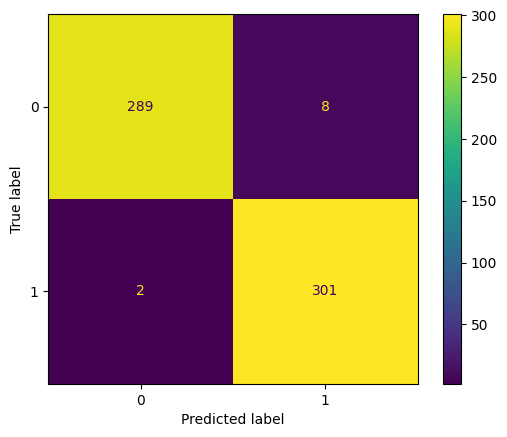

In [37]:
# Predictions on the test split 1
predictions_output_1 = trainer.predict(test_dataset_1)

# Extract predictions and true labels
y_pred_1_ru = np.argmax(predictions_output_1.predictions, axis=-1)
y_true_1 = predictions_output_1.label_ids

print(classification_report(y_true_1, y_pred_1_ru, digits=2))
ConfusionMatrixDisplay.from_predictions(y_true_1, y_pred_1_ru)

# Save to file:
plt.savefig("plots/confusion_matrix_setup_1_roberta.png", dpi=300, bbox_inches='tight')
plt.show()

In [38]:
df_test_1, df_errors_1_ru = extract_errors(test_dataset_1, y_pred_1_ru, columns_to_remove)

# Print how many errors there were
print(f"Number of misclassifications in split 1: {len(df_errors_1_ru)}")

Number of misclassifications in split 1: 10


In [39]:
df_errors_1_ru.to_csv("data/errors_setup_1_ru_roberta.csv", index=False)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       297
           1       0.97      0.99      0.98       303

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



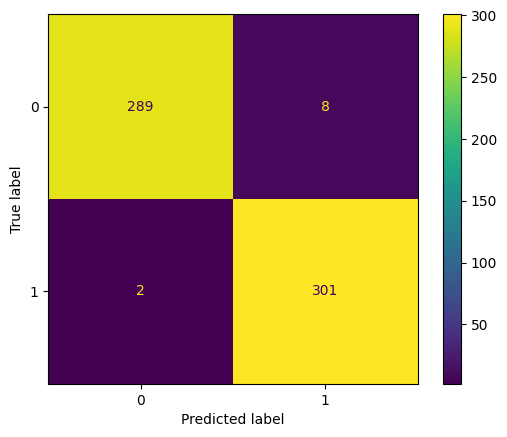

In [40]:
# Predictions on the test split 2
predictions_output_2 = trainer.predict(test_dataset_2)

# Extract predictions and true labels
y_pred_2_ru = np.argmax(predictions_output_2.predictions, axis=-1)
y_true_2 = predictions_output_2.label_ids

print(classification_report(y_true_2, y_pred_2_ru, digits=2))
ConfusionMatrixDisplay.from_predictions(y_true_2, y_pred_2_ru)

# Save to file:
plt.savefig("plots/confusion_matrix_setup_2_roberta.png", dpi=300, bbox_inches='tight')
plt.show()

In [41]:
df_test_2, df_errors_2_ru = extract_errors(test_dataset_2, y_pred_2_ru, columns_to_remove)

# Print how many errors there were
print(f"Number of misclassifications in split 2: {len(df_errors_2_ru)}")

Number of misclassifications in split 2: 10


In [42]:
df_errors_2_ru.to_csv("data/errors_setup_2_ru_roberta.csv", index=False)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       297
           1       0.97      0.99      0.98       303

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



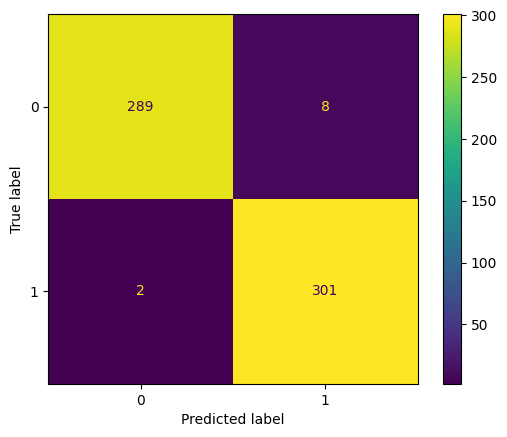

In [43]:
# Predictions on the test split 3
predictions_output_3 = trainer.predict(test_dataset_3)

# Extract predictions and true labels
y_pred_3_ru = np.argmax(predictions_output_3.predictions, axis=-1)
y_true_3 = predictions_output_3.label_ids

print(classification_report(y_true_3, y_pred_3_ru, digits=2))
ConfusionMatrixDisplay.from_predictions(y_true_3, y_pred_3_ru)

# Save to file:
plt.savefig("plots/confusion_matrix_setup_3_roberta.png", dpi=300, bbox_inches='tight')
plt.show()

In [44]:
df_test_3, df_errors_3_ru = extract_errors(test_dataset_3, y_pred_3_ru, columns_to_remove)

# Print how many errors there were
print(f"Number of misclassifications in split 3: {len(df_errors_3_ru)}")

Number of misclassifications in split 3: 10


In [45]:
df_errors_3_ru.to_csv("data/errors_setup_3_ru_roberta.csv", index=False)

## Error Analysis

### Model 1

In [46]:
# Load the errors datasets. Make sure to correct the file paths if needed.
df_errors_1_xlm = pd.read_csv("data/errors_setup_1_xlm_roberta.csv")
df_errors_2_xlm = pd.read_csv("data/errors_setup_2_xlm_roberta.csv")
df_errors_3_xlm = pd.read_csv("data/errors_setup_3_xlm_roberta.csv")

In [47]:
df_errors_1_xlm.head()

,texts,source,word_counts,genre,labels,predicted_label
0,Міръ фантазіи\nТамъ негою веетъ вокругъ ветеро...,Дмитрий Петрович Ознобишин,69.0,poems,0,1
1,В заповеднике на Камчатке сфотографировали мыш...,ria.ru,68.0,news,0,1
2,"Ха, а позади меня сидели школотроны, хрустели ...",pikabu,11.0,social,0,1
3,Утешение\nСкрипит под санями сверкающий снег.\...,Андрей Белый,55.0,poems,0,1
4,"\nI \nКАЛУЖСКИЕ ВЕЧЕРА \nВечер тихий, как ...",chatgpt-4o-latest,104.0,poems,1,0


In [49]:
print(len(df_errors_1_xlm))
print(len(df_errors_2_xlm))
print(len(df_errors_3_xlm))

19
19
19


In [50]:
# We suspect that the three dfs are exactly the same. Let's check this assumption.

# First, compare 1 vs 2
is_1_equal_2 = df_errors_1_xlm.equals(df_errors_2_xlm)

# Then compare 1 vs 3
is_1_equal_3 = df_errors_1_xlm.equals(df_errors_3_xlm)

# Results
print(f"df_errors_1_xlm == df_errors_2_xlm: {is_1_equal_2}")
print(f"df_errors_1_xlm == df_errors_3_xlm: {is_1_equal_3}")

df_errors_1_xlm == df_errors_2_xlm: True
df_errors_1_xlm == df_errors_3_xlm: True


In [51]:
df_errors_1_xlm['genre'].value_counts()

,count
genre,
social,9
poems,8
news,2


In [52]:
# All misclassified news articles belog to the 'human' class.
# Our attacks had no effect on the model's performance.
df_errors_1_xlm_news = df_errors_1_xlm[df_errors_1_xlm['genre'] == 'news']
df_errors_1_xlm_news.head(6)

,texts,source,word_counts,genre,labels,predicted_label
1,В заповеднике на Камчатке сфотографировали мыш...,ria.ru,68.0,news,0,1
7,В Москве пройдет книжный фестиваль «Красная пл...,lenta.ru,181.0,news,0,1


In [53]:
df_errors_1_xlm_poems = df_errors_1_xlm[df_errors_1_xlm['genre'] == 'poems']
df_errors_1_xlm_poems.head(9)

,texts,source,word_counts,genre,labels,predicted_label
0,Міръ фантазіи\nТамъ негою веетъ вокругъ ветеро...,Дмитрий Петрович Ознобишин,69.0,poems,0,1
3,Утешение\nСкрипит под санями сверкающий снег.\...,Андрей Белый,55.0,poems,0,1
4,"\nI \nКАЛУЖСКИЕ ВЕЧЕРА \nВечер тихий, как ...",chatgpt-4o-latest,104.0,poems,1,0
5,"Лежал Лёшика зайка \nНа полке, как в майке. ...",chatgpt-4o-latest,72.0,poems,1,0
8,"Ледяное море\nГромадные белые горы,\nУступы и ...",Владимир Сергеевич Соловьев,63.0,poems,0,1
11,"Певица\nС хозяйкой под руку, спокойно, величав...",Алексей Николаевич Апухтин,275.0,poems,0,1
15,Засохшая береза\nВ глуши на почве раскаленной\...,Иван Саввич Никитин,77.0,poems,0,1
16,"На закате мечты (Уходит свет, преломляясь в кр...",chatgpt-4o-latest,110.0,poems,1,0


In [54]:
df_errors_1_xlm_social = df_errors_1_xlm[df_errors_1_xlm['genre'] == 'social']
df_errors_1_xlm_social.head(9)

,texts,source,word_counts,genre,labels,predicted_label
2,"Ха, а позади меня сидели школотроны, хрустели ...",pikabu,11.0,social,0,1
6,"Пошёл в магазин, сказали цена выросла, потому ...",chatgpt-4o-latest,36.0,social,1,0
9,Вот почему некоторых явно коробит от Макса Фра...,chatgpt-4o-latest,38.0,social,1,0
10,Купить кофе за 200 рублей: нормально. Купить п...,chatgpt-4o-latest,36.0,social,1,0
12,"""Топ-3 шага для успеха: 1. Найти проблему, кот...",chatgpt-4o-latest,27.0,social,1,0
13,Real Gold — это реальная возможность заработка...,chatgpt-4o-latest,35.0,social,1,0
14,И не только координаторы видят сильные стороны...,vk,32.0,social,0,1
17,"Ну конечно, очередной предвор в твиттере разво...",chatgpt-4o-latest,34.0,social,1,0
18,Огромное спасибо за ликбез. Я находила в интер...,pikabu,12.0,social,0,1


### Model 2

In [55]:
df_errors_1_ru = pd.read_csv("data/errors_setup_1_ru_roberta.csv")
df_errors_2_ru = pd.read_csv("data/errors_setup_2_ru_roberta.csv")
df_errors_3_ru = pd.read_csv("data/errors_setup_3_ru_roberta.csv")

In [56]:
print(len(df_errors_1_ru))
print(len(df_errors_2_ru))
print(len(df_errors_3_ru))

10
10
10


In [57]:
# Same assumption is true for the second model.

is_1_equal_2 = df_errors_1_ru.equals(df_errors_2_ru)
is_1_equal_3 = df_errors_1_ru.equals(df_errors_3_ru)

print(f"df_errors_1_ru == df_errors_2_ru: {is_1_equal_2}")
print(f"df_errors_1_ru == df_errors_3_ru: {is_1_equal_3}")

df_errors_1_ru == df_errors_2_ru: True
df_errors_1_ru == df_errors_3_ru: True


In [58]:
df_errors_1_ru['genre'].value_counts()

,count
genre,
social,10


In [59]:
df_errors_1_ru.head(18)

,texts,source,word_counts,genre,labels,predicted_label
0,"Ха, а позади меня сидели школотроны, хрустели ...",pikabu,11.0,social,0,1
1,super turbo turkey puncher 3,pikabu,5.0,social,0,1
2,Короче скоро даже килька пропадёт с прилавков ...,pikabu,21.0,social,0,1
3,"Из нее следует, что человек без водки - собака...",pikabu,20.0,social,0,1
4,Чинуши здесь причем? Вот когда они страну рват...,pikabu,14.0,social,0,1
5,Вот почему некоторых явно коробит от Макса Фра...,chatgpt-4o-latest,38.0,social,1,0
6,Забавно как иногда бывает. Делаешь заказ на Al...,pikabu,470.0,social,0,1
7,"ДА КАКОЙ ТОЛК С ТОГО, ЧТО ОНИ ТАМ ВСЕ РЕШАЮТ? ...",chatgpt-4o-latest,35.0,social,1,0
8,Елена Чебакова Не стоит передёргивать. Вина ле...,fb,79.0,social,0,1
9,Огромное спасибо за ликбез. Я находила в интер...,pikabu,12.0,social,0,1


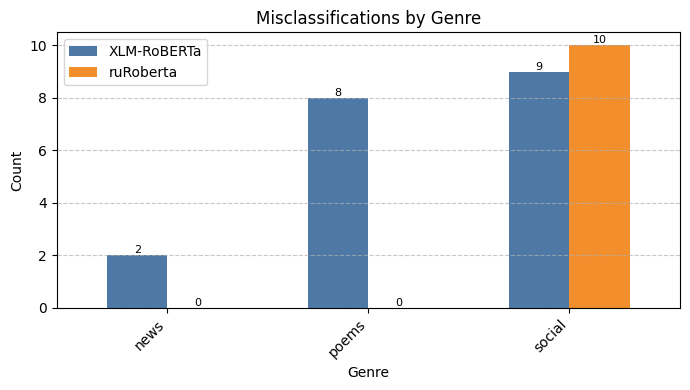

In [61]:
import seaborn as sns

# Step 1: Combine data
genre_counts = (
    pd.concat({
        'XLM-RoBERTa': df_errors_1_xlm['genre'].value_counts(),
        'ruRoberta': df_errors_1_ru['genre'].value_counts()
    }, axis=1)
    .fillna(0)
    .astype(int)
    .sort_index()
)

# Step 2: Define color mapping
color_map = {0: '#4E79A7', 1: '#F28E2B'}
colors = [color_map[i] for i in range(len(genre_counts.columns))]

# Step 3: Plot with smaller figure and narrower bars
ax = genre_counts.plot(
    kind='bar',
    figsize=(7, 4),     # Smaller plot
    width=0.6,          # Narrower bars reduce whitespace
    title="Misclassifications by Genre",
    color=colors
)

# Step 4: Annotate bars with counts
for bars in ax.containers:
    ax.bar_label(bars, label_type='edge', fontsize=8)

# Step 5: Formatting
plt.ylabel("Count")
plt.xlabel("Genre")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save to file
plt.savefig("plots/genre_misclassifications_transformer.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-62-cf0e06539f0e>:9: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(data=error_counts, x='predicted_label', y='count', hue='source', palette=custom_palette)


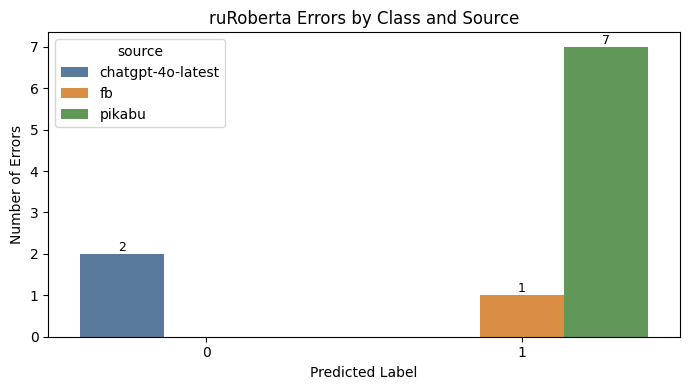

In [62]:
# Plot errors by source for ruRoberta
error_counts = df_errors_1_ru.groupby(['predicted_label', 'source']).size().reset_index(name='count')

# Define consistent color palette
custom_palette = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759']  # extended

# Plot with custom palette
plt.figure(figsize=(7, 4))
ax = sns.barplot(data=error_counts, x='predicted_label', y='count', hue='source', palette=custom_palette)

# Add counts on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9)

plt.title("ruRoberta Errors by Class and Source")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.tight_layout()

# Save to file
plt.savefig("plots/errors_by_genre_ru_roberta.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-63-2e227b7aa6ae>:6: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.barplot(data=error_counts, x='predicted_label', y='count', hue='source', palette=custom_palette)


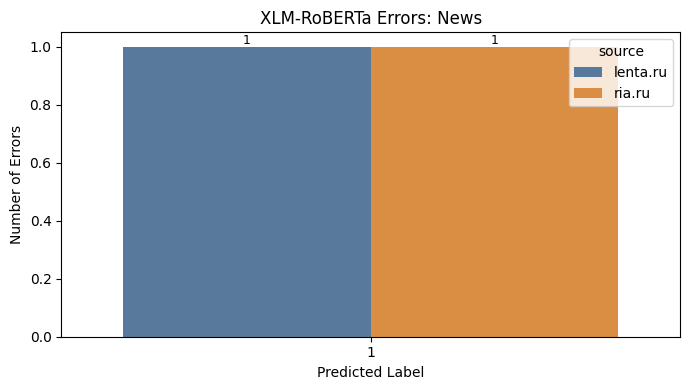

In [63]:
# Plot errors by source for XLM-RoBERTa and news articles
error_counts = df_errors_1_xlm_news.groupby(['predicted_label', 'source']).size().reset_index(name='count')

# Plot with custom palette
plt.figure(figsize=(7, 4))
ax = sns.barplot(data=error_counts, x='predicted_label', y='count', hue='source', palette=custom_palette)

# Add counts on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9)

plt.title("XLM-RoBERTa Errors: News")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.tight_layout()

# Save to file
plt.savefig("plots/errors_by_source_news_xlm_roberta.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-64-27047edfddbe>:6: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(data=error_counts, x='predicted_label', y='count', hue='source', palette=custom_palette)


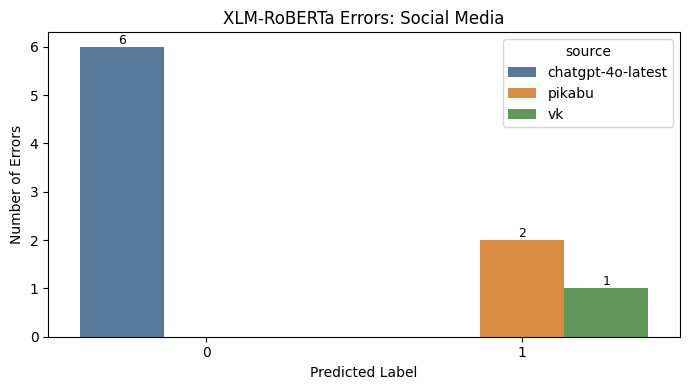

In [64]:
# Plot errors by source for XLM-RoBERTa and social media
error_counts = df_errors_1_xlm_social.groupby(['predicted_label', 'source']).size().reset_index(name='count')

# Plot with custom palette
plt.figure(figsize=(7, 4))
ax = sns.barplot(data=error_counts, x='predicted_label', y='count', hue='source', palette=custom_palette)

# Add counts on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9)

plt.title("XLM-RoBERTa Errors: Social Media")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.tight_layout()

# Save to file
plt.savefig("plots/errors_by_source_social_xlm_roberta.png", dpi=300, bbox_inches='tight')
plt.show()

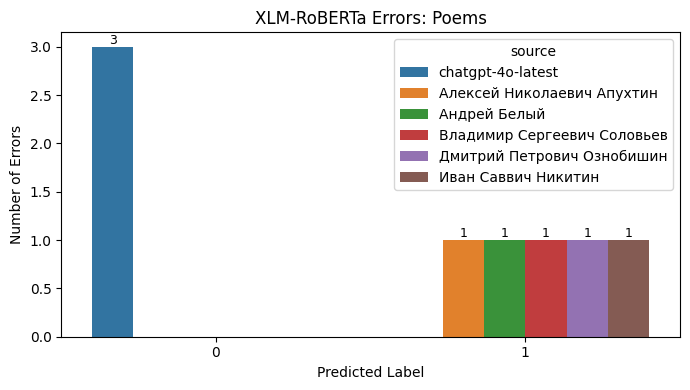

In [65]:
# Plot errors by source for XLM-RoBERTa and poems
error_counts = df_errors_1_xlm_poems.groupby(['predicted_label', 'source']).size().reset_index(name='count')

# Plot using default Seaborn colors
plt.figure(figsize=(7, 4))
ax = sns.barplot(data=error_counts, x='predicted_label', y='count', hue='source')

# Add counts on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9)

plt.title("XLM-RoBERTa Errors: Poems")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.tight_layout()

# Save to file
plt.savefig("plots/errors_by_source_poems_xlm_roberta.png", dpi=300, bbox_inches='tight')
plt.show()